### Import the required libraries -

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import os

### Load the dataset -

In [4]:
import pandas as pd

filepath_dict = {'yelp':   '/content/yelp_labelled.txt',
                 'amazon': '/content/amazon_cells_labelled.txt',
                 'imdb':   '/content/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(f"{df.head()}\n\n{df.tail()}")

                                            sentence  label source
0                           Wow... Loved this place.      1   yelp
1                                 Crust is not good.      0   yelp
2          Not tasty and the texture was just nasty.      0   yelp
3  Stopped by during the late May bank holiday of...      1   yelp
4  The selection on the menu was great and so wer...      1   yelp

                                              sentence  label source
743  I just got bored watching Jessice Lange take h...      0   imdb
744  Unfortunately, any virtue in this film's produ...      0   imdb
745                   In a word, it is embarrassing.        0   imdb
746                               Exceptionally bad!        0   imdb
747  All in all its an insult to one's intelligence...      0   imdb


### Split the data into training/testing sets -

In [20]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

# Split the data into training/testing sets
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

# Tokenize the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])
for word in ['the', 'all','dishes']:
    print(f'{word}: {tokenizer.word_index[word]}')

# Pad the sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(f"\n{X_train[0, :]}")

Of all the dishes, the salmon was the best, but all were great.
[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]
the: 1
all: 43
dishes: 171

[  1  10   3 282 739  25   8 208  30  64 459 230  13   1 124   5 231   8
  58   5  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


### Define the model -

In [21]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          174700    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_________________________________________________________________


### Train the model -

In [22]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/100
75/75 [==============================] - 31s 8ms/step - loss: 0.6912 - accuracy: 0.5306 - val_loss: 0.6683 - val_accuracy: 0.5920
Epoch 2/100
75/75 [==============================] - 0s 6ms/step - loss: 0.5735 - accuracy: 0.8436 - val_loss: 0.5146 - val_accuracy: 0.7240
Epoch 3/100
75/75 [==============================] - 0s 6ms/step - loss: 0.1984 - accuracy: 0.9422 - val_loss: 0.4692 - val_accuracy: 0.8200
Epoch 4/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0407 - accuracy: 0.9939 - val_loss: 0.4733 - val_accuracy: 0.7960
Epoch 5/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.5415 - val_accuracy: 0.8160
Epoch 6/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.5484 - val_accuracy: 0.8040
Epoch 7/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.5794 - val_accuracy: 0.8200
Epoch 8/100


### Evaluate and visualize the model -

Training Accuracy: 1.0000
Testing Accuracy:  0.8040


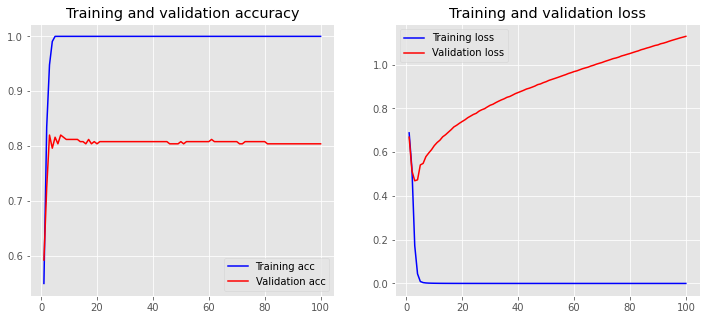

In [23]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)